<a href="https://colab.research.google.com/github/shimu25/python-projects/blob/main/dep_lear_alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
# For handling imbalance
from imblearn.over_sampling import SMOTE



In [14]:
df_tabular = pd.read_csv('alzheimer_dataset.csv')

In [15]:
#Handle Categorical Variables
print("Data types of df_tabular:")
print(df_tabular.dtypes)

categorical_cols = df_tabular.select_dtypes(include=['object']).columns

if len(categorical_cols) == 0:
    print("\nNo object-type categorical columns found. Checking unique values for 'Diagnosis' column.")
    print(f"Unique values in 'Diagnosis': {df_tabular['Diagnosis'].unique()}")
    if df_tabular['Diagnosis'].dtype == 'object':
        print("\n'Diagnosis' column is of object type and will be encoded.")
    else:
        print("\nAll relevant columns appear to be numerical already.")
else:
    print(f"\nCategorical columns identified: {list(categorical_cols)}")

Data types of df_tabular:
Patient_ID            int64
Age                   int64
Memory_Loss           int64
Confusion             int64
Language_Problems     int64
Mood_Swings           int64
Disorientation        int64
Diagnosis            object
dtype: object

Categorical columns identified: ['Diagnosis']


In [16]:
label_encoder = LabelEncoder()
df_tabular['Diagnosis'] = label_encoder.fit_transform(df_tabular['Diagnosis'])

print("Data types after encoding 'Diagnosis' column:")
print(df_tabular.dtypes)
print("Unique values in 'Diagnosis' after encoding:")
print(df_tabular['Diagnosis'].unique())

Data types after encoding 'Diagnosis' column:
Patient_ID           int64
Age                  int64
Memory_Loss          int64
Confusion            int64
Language_Problems    int64
Mood_Swings          int64
Disorientation       int64
Diagnosis            int64
dtype: object
Unique values in 'Diagnosis' after encoding:
[1 0]


In [17]:
#Eliminate Correlated Features
corr_matrix = df_tabular.corr(method='pearson')
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                   Patient_ID       Age  Memory_Loss  Confusion  \
Patient_ID           1.000000  0.054165     0.045246   0.026416   
Age                  0.054165  1.000000     0.469685   0.498973   
Memory_Loss          0.045246  0.469685     1.000000   0.210306   
Confusion            0.026416  0.498973     0.210306   1.000000   
Language_Problems    0.004488  0.077982     0.007178   0.066133   
Mood_Swings         -0.041850  0.173057     0.094778   0.053042   
Disorientation       0.022870  0.367455     0.180192   0.193723   
Diagnosis           -0.016172 -0.402806    -0.465606  -0.443519   

                   Language_Problems  Mood_Swings  Disorientation  Diagnosis  
Patient_ID                  0.004488    -0.041850        0.022870  -0.016172  
Age                         0.077982     0.173057        0.367455  -0.402806  
Memory_Loss                 0.007178     0.094778        0.180192  -0.465606  
Confusion                   0.066133     0.053042        0.1

In [18]:
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column].abs() > 0.9)]

if len(to_drop) > 0:
    df_tabular = df_tabular.drop(columns=to_drop)
    print(f"Dropped highly correlated features: {to_drop}")
else:
    print("No highly correlated features (correlation > 0.9) found to drop.")

print("Shape of df_tabular after dropping highly correlated features:")
print(df_tabular.shape)
print("Columns remaining:")
print(df_tabular.columns.tolist())

No highly correlated features (correlation > 0.9) found to drop.
Shape of df_tabular after dropping highly correlated features:
(550, 8)
Columns remaining:
['Patient_ID', 'Age', 'Memory_Loss', 'Confusion', 'Language_Problems', 'Mood_Swings', 'Disorientation', 'Diagnosis']


In [19]:
#Balancing
X = df_tabular.drop(['Diagnosis', 'Patient_ID'], axis=1)
y = df_tabular['Diagnosis']

print("Original class distribution:")
print(y.value_counts())

Original class distribution:
Diagnosis
1    468
0     82
Name: count, dtype: int64


In [20]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Class distribution after SMOTE:")
print(y_resampled.value_counts())

Class distribution after SMOTE:
Diagnosis
1    468
0    468
Name: count, dtype: int64


In [21]:
#Normalize Numerical Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
X_scaled = pd.DataFrame(X_scaled, columns=X_resampled.columns)

print("Shape of X_scaled after normalization:")
print(X_scaled.shape)
print("First 5 rows of X_scaled:")
print(X_scaled.head())

Shape of X_scaled after normalization:
(936, 6)
First 5 rows of X_scaled:
        Age  Memory_Loss  Confusion  Language_Problems  Mood_Swings  \
0  1.147779     0.837746  -1.140068          -0.216748    -0.440315   
1 -0.233762    -1.193679   0.877141          -0.216748    -0.440315   
2 -2.047035    -1.193679  -1.140068          -0.216748    -0.440315   
3 -0.320109    -1.193679  -1.140068          -0.216748    -0.440315   
4 -0.838186    -1.193679  -1.140068          -0.216748    -0.440315   

   Disorientation  
0         0.96225  
1        -1.03923  
2        -1.03923  
3        -1.03923  
4         0.96225  


In [26]:
#Split into training, validation, and test sets.

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_temp:", X_temp.shape)
print("Shape of y_temp:", y_temp.shape)

Shape of X_train: (748, 6)
Shape of y_train: (748,)
Shape of X_temp: (188, 6)
Shape of y_temp: (188,)


In [23]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (748, 6)
Shape of y_train: (748,)
Shape of X_val: (94, 6)
Shape of y_val: (94,)
Shape of X_test: (94, 6)
Shape of y_test: (94,)


In [27]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
print("Random Forest Classifier trained successfully.")

Random Forest Classifier trained successfully.


In [28]:
# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_val = model.predict(X_val)

accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)

print(f"Validation Accuracy: {accuracy_val:.4f}")
print(f"Validation Precision: {precision_val:.4f}")
print(f"Validation Recall: {recall_val:.4f}")
print(f"Validation F1-score: {f1_val:.4f}")

Validation Accuracy: 0.9043
Validation Precision: 0.9038
Validation Recall: 0.9216
Validation F1-score: 0.9126


In [29]:
y_pred_test = model.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")
print(f"Test F1-score: {f1_test:.4f}")

Test Accuracy: 0.9787
Test Precision: 1.0000
Test Recall: 0.9500
Test F1-score: 0.9744


<Figure size 600x500 with 0 Axes>

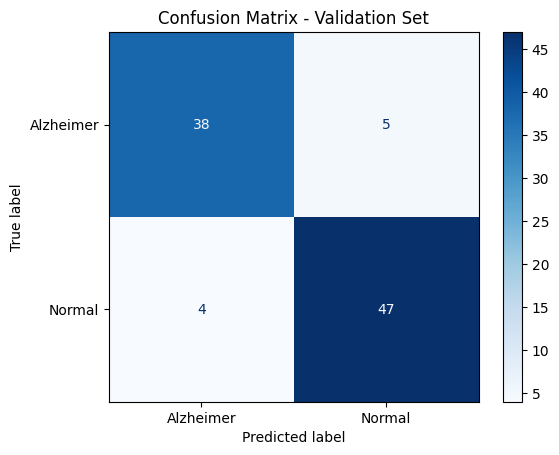

<Figure size 600x500 with 0 Axes>

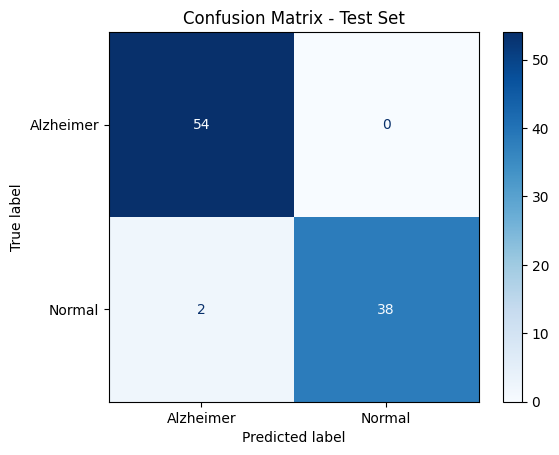

In [30]:

#Generate Confusion Matrices
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate Confusion Matrix for Validation Set
cm_val = confusion_matrix(y_val, y_pred_val)

# Create and display Confusion Matrix plot for Validation Set
plt.figure(figsize=(6, 5))
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=label_encoder.classes_)
disp_val.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

# Generate Confusion Matrix for Test Set
cm_test = confusion_matrix(y_test, y_pred_test)

# Create and display Confusion Matrix plot for Test Set
plt.figure(figsize=(6, 5))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_encoder.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

In [31]:
#Save Trained Model
joblib.dump(model, 'tabular_model.pkl')
print("Trained model saved successfully as 'tabular_model.pkl'.")

Trained model saved successfully as 'tabular_model.pkl'.


In [32]:
#image data classification


In [33]:
from google.colab import files
import zipfile
import io
import os

# ZIP file upload dialog
uploaded = files.upload()  # তোমার ZIP file select


Saving archive.zip to archive.zip


In [34]:
# ZIP file name automatically detect
zip_name = list(uploaded.keys())[0]

# Unzip to 'dataset/' folder
with zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), 'r') as zip_ref:
    zip_ref.extractall('dataset')

# Folder structure check
import os
print(os.listdir('dataset'))


['Alzheimer_s Dataset']


In [35]:
train_path = "dataset/Alzheimer_s Dataset/train/"
test_path  = "dataset/Alzheimer_s Dataset/test/"


In [36]:
#Image Parameters and Set Up Data Generators
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator for Training set with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator for Validation set (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

# ImageDataGenerator for Test set (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

print(f"Image dimensions set to {IMG_WIDTH}x{IMG_HEIGHT} with a batch size of {BATCH_SIZE}.")
print("ImageDataGenerators for train, validation, and test sets have been created.")

Image dimensions set to 128x128 with a batch size of 32.
ImageDataGenerators for train, validation, and test sets have been created.


In [37]:
#Load and Prepare Training Data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Training image generator created.")
print(f"Found {train_generator.samples} images belonging to {train_generator.num_classes} classes.")

Found 2613 images belonging to 4 classes.
Training image generator created.
Found 2613 images belonging to 4 classes.


In [38]:
#Load and Prepare Validation Data
validation_generator = val_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Validation image generator created.")
print(f"Found {validation_generator.samples} images belonging to {validation_generator.num_classes} classes.")

Found 317 images belonging to 4 classes.
Validation image generator created.
Found 317 images belonging to 4 classes.


In [39]:
#Load and Prepare Test Data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Test image generator created.")
print(f"Found {test_generator.samples} images belonging to {test_generator.num_classes} classes.")

Found 317 images belonging to 4 classes.
Test image generator created.
Found 317 images belonging to 4 classes.


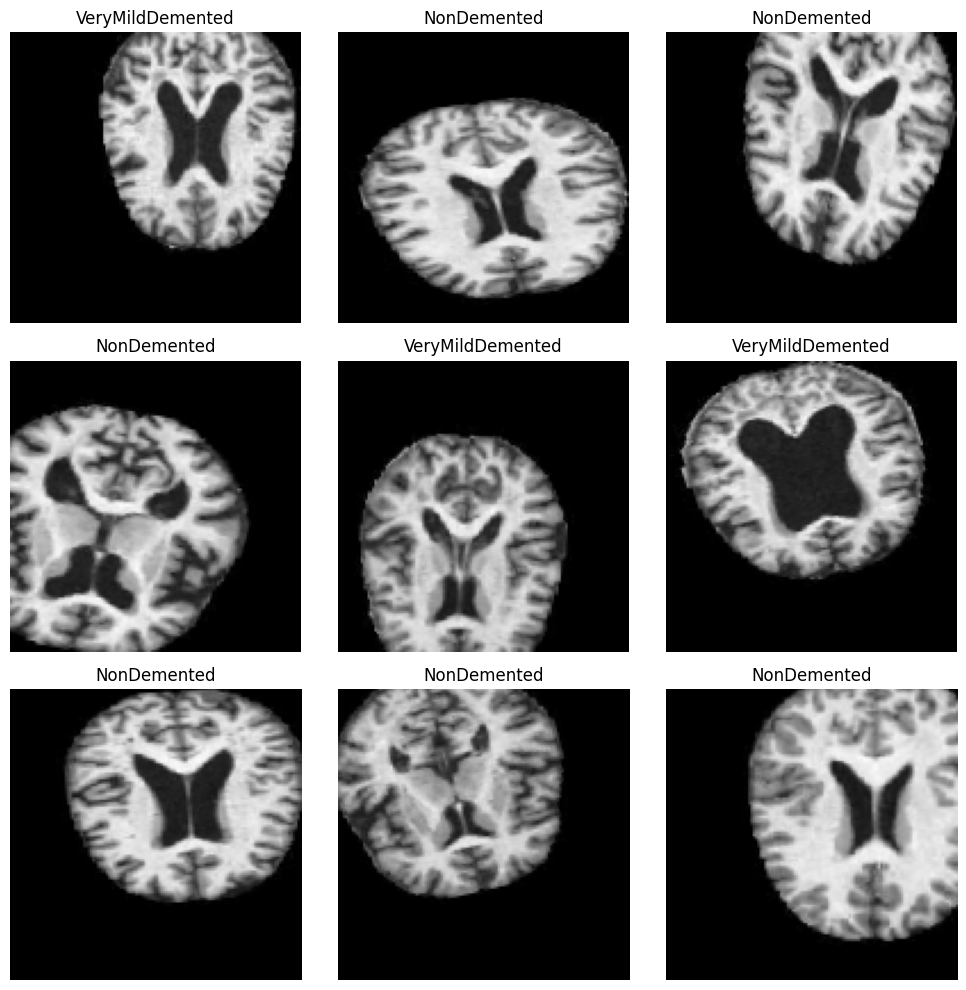

In [40]:
#Verify Data Loading
import matplotlib.pyplot as plt

# Get a batch of training images and labels
images, labels = next(train_generator)

# Get class names from the generator
class_names = list(train_generator.class_indices.keys())

# Create a figure to display images
plt.figure(figsize=(10, 10))

# Display the first 9 images from the batch
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])

    # Get the class label (one-hot encoded) and convert to class name
    class_index = np.argmax(labels[i])
    plt.title(class_names[class_index])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [41]:
#Define CNN Architecture
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Get the number of classes from the train_generator
num_classes = train_generator.num_classes

# Initialize the Sequential model
model_cnn = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flatten the output for the Dense layers
    Flatten(),

    # Dense layers for classification
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax') # Output layer with softmax for multi-class classification
])

# Display model summary
model_cnn.summary()

print("CNN model architecture defined successfully.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,940,868 (49.37 MB)

 Trainable params: 12,940,868 (49.37 MB)

 Non-trainable params: 0 (0.00 B)

CNN model architecture defined successfully.


In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Get the number of classes from the train_generator
num_classes = train_generator.num_classes

# Initialize the Sequential model
model_cnn = Sequential([
    # Input Layer explicitly defined
    Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flatten the output for the Dense layers
    Flatten(),

    # Dense layers for classification
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax') # Output layer with softmax for multi-class classification
])

# Display model summary
model_cnn.summary()

print("CNN model architecture defined successfully.")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,940,868 (49.37 MB)

 Trainable params: 12,940,868 (49.37 MB)

 Non-trainable params: 0 (0.00 B)

CNN model architecture defined successfully.


In [43]:
model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("CNN model compiled successfully with Adam optimizer, categorical_crossentropy loss, and accuracy metric.")

CNN model compiled successfully with Adam optimizer, categorical_crossentropy loss, and accuracy metric.


## Train the CNN Model

### Subtask:
Train the compiled CNN model using the training data generator (`train_generator`) and evaluate its performance on the validation data generator (`validation_generator`).

#### Instructions
1.  Use the `model_cnn.fit()` method to train the model.
2.  Specify `train_generator` for training data and `validation_generator` for validation data.
3.  Define the number of `epochs` for training (e.g., 10-20).
4.  Consider using callbacks like `EarlyStopping` or `ModelCheckpoint` for better training control, although not strictly required for this initial step.

**Reasoning**:
The next logical step is to train the CNN model using the previously defined data generators and the compiled model. I will use the `fit()` method, specifying the training and validation generators and a suitable number of epochs.



In [44]:
history = model_cnn.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # Training for 10 epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

print("CNN model training complete.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 218ms/step - accuracy: 0.4720 - loss: 1.2526 - val_accuracy: 0.4236 - val_loss: 1.2293
Epoch 2/10
 1/81 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4688 - loss: 0.9067

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4688 - loss: 0.9067 - val_accuracy: 0.4167 - val_loss: 1.2172
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.5392 - loss: 1.0075 - val_accuracy: 0.4201 - val_loss: 1.2199
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7500 - loss: 0.8116 - val_accuracy: 0.4097 - val_loss: 1.2258
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.5181 - loss: 1.0087 - val_accuracy: 0.4062 - val_loss: 1.2305
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5312 - loss: 1.1246 - val_accuracy: 0.4375 - val_loss: 1.1894
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.5436 - loss: 0.9857 - val_accuracy: 0.4826 - val_loss: 1.1513
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5938 - loss: 0.9500 - val_accuracy: 0.4618 - val_loss: 1.1550
Epoch 9/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.5686 - loss: 0.9588 - val_accuracy: 0.4896 - val_loss

In [45]:
import math

history = model_cnn.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / train_generator.batch_size),
    epochs=10,  # Training for 10 epochs
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples / validation_generator.batch_size)
)

print("CNN model training complete.")

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.5641 - loss: 0.9165 - val_accuracy: 0.4953 - val_loss: 1.0599
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.5300 - loss: 0.9853 - val_accuracy: 0.5047 - val_loss: 1.0639
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.5647 - loss: 0.9438 - val_accuracy: 0.5047 - val_loss: 1.0521
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.5690 - loss: 0.9164 - val_accuracy: 0.4984 - val_loss: 1.0883
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.5447 - loss: 0.9148 - val_accuracy: 0.4700 - val_loss: 1.0465
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.5912 - loss: 0.8942 - val_accuracy: 0.4953 - val_loss: 1.0411
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.5762 - loss: 0.8899 - val_accuracy: 0.4763 - val_loss: 1.0864
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.5788 - loss: 0.8753 - val_accu

In [46]:
#Evaluate CNN Model on Test Data
import numpy as np
from sklearn.metrics import classification_report
import math

# 1. Predict probabilities for the test set
steps_test = math.ceil(test_generator.samples / test_generator.batch_size)
y_pred_prob = model_cnn.predict(test_generator, steps=steps_test)

# 2. Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# 3. Obtain true class labels from the test_generator
y_true_labels = test_generator.classes[:test_generator.samples]

# Ensure that the number of predictions matches the number of true labels
# In case the last batch was partial, prediction might have more samples if not handled correctly by steps parameter
# But with math.ceil and flow_from_directory, they should match
assert len(y_pred_labels) == len(y_true_labels), "Mismatch in number of predicted and true labels"

# Get class names for the report
class_names = list(test_generator.class_indices.keys())

# 5. Generate and print a classification report
print("\nClassification Report for Test Data:")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step

Classification Report for Test Data:
                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00        78
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.40      0.37      0.39       131
VeryMildDemented       0.30      0.60      0.40        96

        accuracy                           0.34       317
       macro avg       0.18      0.24      0.20       317
    weighted avg       0.26      0.34      0.28       317



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 800x700 with 0 Axes>

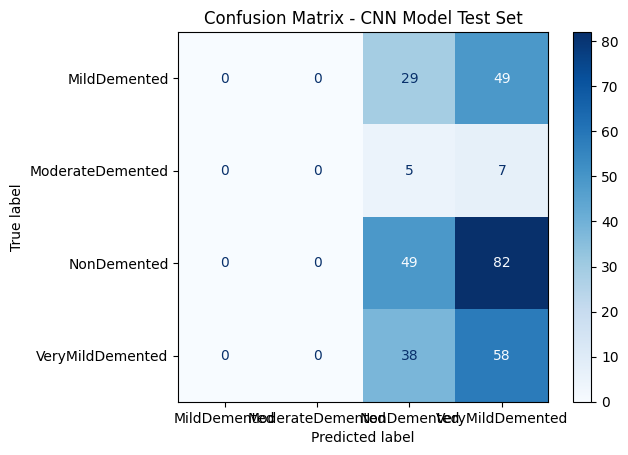

Confusion matrix for the CNN model on the test set generated and displayed.


In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate Confusion Matrix for Test Set
cm_test_cnn = confusion_matrix(y_true_labels, y_pred_labels)

# Create and display Confusion Matrix plot for Test Set
plt.figure(figsize=(8, 7))
disp_test_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_test_cnn, display_labels=class_names)
disp_test_cnn.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CNN Model Test Set")
plt.show()

print("Confusion matrix for the CNN model on the test set generated and displayed.")

In [49]:
model_cnn.save('image_model.keras')
print("Trained CNN model saved successfully as 'image_model.keras'.")

Trained CNN model saved successfully as 'image_model.keras'.


In [81]:
#Load Trained Models
import joblib
import tensorflow as tf

# Load the tabular model
tabular_model = joblib.load('tabular_model.pkl')
print("Tabular model 'tabular_model.pkl' loaded successfully.")

# Load the image model
image_model = tf.keras.models.load_model('image_model.keras')
print("Image model 'image_model.keras' loaded successfully.")

Tabular model 'tabular_model.pkl' loaded successfully.
Image model 'image_model.keras' loaded successfully.


In [82]:
#Create User Interface for Tabular Input
from ipywidgets import IntText, Dropdown, Button, VBox
from IPython.display import display

# Create IntText widget for Age
age_input = IntText(
    value=70,
    description='Age:',
    disabled=False
)

# Create Dropdown widgets for binary symptoms (Memory_Loss, Confusion, Language_Problems, Mood_Swings, Disorientation)
memory_loss_input = Dropdown(
    options=[('No', 0), ('Yes', 1)],
    value=0,
    description='Memory Loss:',
    disabled=False,
)

confusion_input = Dropdown(
    options=[('No', 0), ('Yes', 1)],
    value=0,
    description='Confusion:',
    disabled=False,
)

language_problems_input = Dropdown(
    options=[('No', 0), ('Yes', 1)],
    value=0,
    description='Language Problems:',
    disabled=False,
)

mood_swings_input = Dropdown(
    options=[('No', 0), ('Yes', 1)],
    value=0,
    description='Mood Swings:',
    disabled=False,
)

disorientation_input = Dropdown(
    options=[('No', 0), ('Yes', 1)],
    value=0,
    description='Disorientation:',
    disabled=False,
)

# Create a button for prediction
predict_tabular_button = Button(description="Predict Tabular")

# Arrange widgets vertically
tabular_input_widgets = VBox([
    age_input,
    memory_loss_input,
    confusion_input,
    language_problems_input,
    mood_swings_input,
    disorientation_input,
    predict_tabular_button
])

print("Tabular input interface created.")
display(tabular_input_widgets)

Tabular input interface created.


In [84]:
#Create User Interface for Image Input


from google.colab import files
from IPython.display import display, HTML

# Create a button for image upload
display(HTML("<h4>Upload Image for Prediction</h4>"))
uploaded_image = files.upload()

print("Image upload interface displayed. Please upload an image file.")

Saving 32 (4).jpg to 32 (4).jpg
Image upload interface displayed. Please upload an image file.


In [85]:
#Preprocess User Inputs for Prediction
import pandas as pd
import numpy as np
import tensorflow as tf

# 1. Extract values from widgets
tabular_data = {
    'Age': [age_input.value],
    'Memory_Loss': [memory_loss_input.value],
    'Confusion': [confusion_input.value],
    'Language_Problems': [language_problems_input.value],
    'Mood_Swings': [mood_swings_input.value],
    'Disorientation': [disorientation_input.value]
}

# 2. Create a pandas DataFrame
# Ensure column order matches X_resampled (used for training scaler)
tabular_input_df = pd.DataFrame(tabular_data)
tabular_input_df = tabular_input_df[X_resampled.columns] # Reorder to match training columns

# 3. Use the previously fitted scaler to transform tabular input
processed_tabular_input = scaler.transform(tabular_input_df)

# 4. Get the filename of the uploaded image
image_filename = list(uploaded_image.keys())[0]

# 5. Load the uploaded image
img = tf.keras.utils.load_img(image_filename, target_size=(IMG_WIDTH, IMG_HEIGHT))

# 6. Convert the loaded image to a NumPy array
img_array = tf.keras.utils.img_to_array(img)

# 7. Rescale the pixel values
img_array_rescaled = img_array / 255.0

# 8. Expand the dimensions to include a batch dimension
processed_image_input = np.expand_dims(img_array_rescaled, axis=0)

# 9. Print the shape of the processed inputs
print(f"Shape of processed tabular input: {processed_tabular_input.shape}")
print(f"Shape of processed image input: {processed_image_input.shape}")

print("User inputs preprocessed successfully.")

Shape of processed tabular input: (1, 6)
Shape of processed image input: (1, 128, 128, 3)
User inputs preprocessed successfully.


In [86]:

#Make Predictions from Tabular Model
tabular_prediction = tabular_model.predict(processed_tabular_input)
print(f"Tabular model prediction: {tabular_prediction}")

# Assuming the tabular model outputs a single class label directly
# If it outputs probabilities for binary classification, interpret it:
# For binary classification where 0 is 'No Alzheimer's' and 1 is 'Alzheimer's'
# if tabular_prediction.ndim > 1 and tabular_prediction.shape[1] > 1:
#     # If it's a multi-class output (e.g., softmax probabilities)
#     predicted_class_tabular = np.argmax(tabular_prediction, axis=1)
# else:
#     # If it's a single probability for the positive class (e.g., sigmoid output)
#     predicted_class_tabular = (tabular_prediction > 0.5).astype(int)

predicted_class_tabular = tabular_prediction[0] # Assuming the model directly outputs the class label

print(f"Predicted class from tabular model: {predicted_class_tabular}")

Tabular model prediction: [1]
Predicted class from tabular model: 1


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [87]:
import pandas as pd
import numpy as np

# Convert the processed_tabular_input numpy array back to a DataFrame with original column names
# X_resampled.columns holds the original feature names from training
tabular_input_df_for_prediction = pd.DataFrame(processed_tabular_input, columns=X_resampled.columns)

tabular_prediction = tabular_model.predict(tabular_input_df_for_prediction)
print(f"Tabular model prediction: {tabular_prediction}")

# Assuming the model directly outputs the class label (0 or 1)
predicted_class_tabular = tabular_prediction[0]

print(f"Predicted class from tabular model: {predicted_class_tabular}")

Tabular model prediction: [1]
Predicted class from tabular model: 1


In [88]:
#Make Predictions from Image Model

import numpy as np

# Make prediction using the image model
image_predictions = image_model.predict(processed_image_input)

# Convert probabilities to a single class label
predicted_class_image = np.argmax(image_predictions, axis=1)[0]

# Get class names from the test_generator to map the predicted index to a meaningful label
class_names_image = list(test_generator.class_indices.keys())
predicted_class_name_image = class_names_image[predicted_class_image]

print(f"Image model prediction probabilities: {image_predictions}")
print(f"Predicted class index from image model: {predicted_class_image}")
print(f"Predicted class name from image model: {predicted_class_name_image}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Image model prediction probabilities: [[1.0276604e-03 1.5898990e-04 9.4360703e-01 5.5206254e-02]]
Predicted class index from image model: 2
Predicted class name from image model: NonDemented


In [89]:
#Combine Predictions for Final Decision
import numpy as np

# Map tabular model output (0 or 1) to diagnosis strings
# Based on label_encoder.classes_ and unique values in df_tabular['Diagnosis'] before encoding:
# 1 corresponds to 'NonDemented', 0 corresponds to 'Demented'
if predicted_class_tabular == 1:
    tabular_diagnosis_text = 'NonDemented'
else:
    tabular_diagnosis_text = 'Demented'

print(f"Tabular model diagnosis (text): {tabular_diagnosis_text}")

# Implement conditional logic for final decision
if predicted_class_tabular == 1:
    final_combined_diagnosis = 'NonDemented'
else:
    # If tabular model predicts 'Demented' (0), use the image model's specific diagnosis
    final_combined_diagnosis = predicted_class_name_image

print(f"Final combined diagnosis: {final_combined_diagnosis}")


Tabular model diagnosis (text): NonDemented
Final combined diagnosis: NonDemented


In [91]:
#Display Final Prediction
print("\n--- Final Alzheimer's Disease Diagnosis ---")
print(f"Based on the provided tabular data and image, the final combined diagnosis is: {final_combined_diagnosis}")
print(f"\nDetails:")
print(f"- Tabular Model's Prediction: {tabular_diagnosis_text}")
print(f"- Image Model's Prediction: {predicted_class_name_image}")

if final_combined_diagnosis == 'NonDemented':
    print("\nInterpretation: The models suggest that the patient is currently not showing signs of Alzheimer's Disease based on the provided information.")
else:
    print(f"\nInterpretation: The models suggest that the patient may be experiencing {final_combined_diagnosis} Alzheimer's Disease based on the provided information.")


--- Final Alzheimer's Disease Diagnosis ---
Based on the provided tabular data and image, the final combined diagnosis is: NonDemented

Details:
- Tabular Model's Prediction: NonDemented
- Image Model's Prediction: NonDemented

Interpretation: The models suggest that the patient is currently not showing signs of Alzheimer's Disease based on the provided information.
